# Retrieving Tweets Using SNSCRAPE and Dataset Analysis


In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import re
import time
import numpy as np
import datetime as dt
from pytz import timezone, all_timezones
import matplotlib.pyplot as plt
import seaborn as sns

## Time Settings

In [2]:
start_time = dt.datetime(2022,6,10,2,0,0)
start_time_jst = timezone('Japan').localize(start_time)
start_utc_timestamp = start_time_jst.astimezone(timezone('UTC')).timestamp()

end_time = dt.datetime(2022,6,11,2,0,0)
end_time_jst = timezone('Japan').localize(end_time)
end_utc_timestamp = end_time_jst.astimezone(timezone('UTC')).timestamp()

print(start_time_jst, end_time_jst)

2022-06-10 02:00:00+09:00 2022-06-11 02:00:00+09:00


## Extracting Tweets

In [41]:
# query used to get tweets
query = f'since_time:{int(start_utc_timestamp)} until_time:{int(end_utc_timestamp)} near:"Japan"'

# column names for the dataframe containing information from tweets
column_names = ['tweet_date', 'user_id', 'likes','replies','retweets','quoted_count',
                'contains_media','contains_links','conversation_id','hashtags','cashtags','tweet_content',
                'account_date','user_verified','followers','following','total_tweets',
                'total_likes','total_media_tweets','protected','user_location','language','device']
                
                
tweets = [] # tweets will be stored here before being converted into pandas df

while True:
    
    time.sleep(2) # this allows for the kernel to be interrupted without losing data
    
    # brake the loop if the time of the last tweet is smaller or equal to our end time (5 sec padding)
    if len(tweets)>0:
        if int(tweets[-1][0].timestamp()) <= start_utc_timestamp+5:
            break
        
    try:

        # loop to iterate over the tweets
        for tweet in sntwitter.TwitterSearchScraper(query).get_items():
            
            if tweet.lang != "ja": # ignore non-japanese tweets
                continue
                
            else:
                # append all variables of interest into the tweets list
                tweets.append([tweet.date, tweet.user.id,  

                               tweet.likeCount, tweet.replyCount, tweet.retweetCount, tweet.quoteCount,
                               tweet.media, tweet.outlinks, tweet.conversationId, # tweet related information

                               tweet.hashtags, tweet.cashtags, # hashtags and cashtags

                               re.sub("\n", "", tweet.content), # remove new lines from the tweet content
                               
                                # user related information
                               tweet.user.created, tweet.user.verified, tweet.user.followersCount,
                               tweet.user.friendsCount,tweet.user.statusesCount, tweet.user.favouritesCount,
                               tweet.user.mediaCount,tweet.user.protected, tweet.user.location,

                               tweet.lang, tweet.sourceLabel]) #language of the tweet and type of device used
                
                # gives and update on the progress
                if len(tweets) % 5000 == 0:
                    print(f'retrieved {len(tweets)} tweets and last tweet was made at {tweets[-1][0]}')
    except:
        # if the code brakes for some reason, this will cause it to restart 1 second from the last tweet
        # that was analyzed. Subtracting 1 second from both times as sometimes twitter query
        # fails to retrieve tweets for some time windows. Reason unkown.
        start_utc_timestamp -= 1
        end_utc_timestamp = int(tweets[-1][0].timestamp())-1
        query = f'since_time:{int(start_utc_timestamp)} until_time:{int(end_utc_timestamp)} near:"Japan"'
        print(f'query fialed. Adjusting query time. Current count of tweets is {len(tweets)}')


In [5]:
# Convert tweets list into pandas df
df = pd.DataFrame(tweets, columns=column_names)
df.shape

(3562251, 23)

In [9]:
# Peak at the df
df.head(3)

,tweet_date,user_id,likes,replies,retweets,quoted_count,contains_media,contains_links,conversation_id,hashtags,...,user_verified,followers,following,total_tweets,total_likes,total_media_tweets,protected,user_location,language,device
0,2022-06-10 16:58:51+00:00,173143804,0,0,0,0,NaN,NaN,1535305506218450944,NaN,...,False,734,384,76115,23808,5661,False,福岡県,ja,Twitter for iPhone
1,2022-06-10 16:58:51+00:00,146142843,0,0,0,0,NaN,NaN,1535305505954234368,['スパイファミリー'],...,False,409,221,149670,9204,3635,False,こおりやま,ja,Twitter for iPhone
2,2022-06-10 16:58:51+00:00,2884471884,0,1,1,0,NaN,NaN,1535302493777047553,NaN,...,False,198,436,19873,1627,328,False,日本 東京,ja,Twitter for iPhone


In [10]:
# show all columns
df.columns

Index(['tweet_date', 'user_id', 'likes', 'replies', 'retweets', 'quoted_count',
       'contains_media', 'contains_links', 'conversation_id', 'hashtags',
       'cashtags', 'tweet_content', 'account_date', 'user_verified',
       'followers', 'following', 'total_tweets', 'total_likes',
       'total_media_tweets', 'protected', 'user_location', 'language',
       'device'],
      dtype='object')

In [11]:
# save pandas df as a csv file
df.to_csv('20220610_tweets.csv.gz', index=False, encoding='utf_8_sig',compression='gzip')

In [3]:
# read pandas df as a csv file
df = pd.read_csv('20220610_tweets.csv.gz', encoding='utf_8_sig',compression='gzip',
                 lineterminator='\n', low_memory=False)

## Dataset Exploration

We have 3,562,251 tweets collected over a period of 24h. This dataset contains all of tweets that were made in Japan and in Japanese language from 2022-06-10 01:59:28 to 2022-06-11 01:58:51 Japan time (Friday 2 AM - Saturday 2 AM).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3562251 entries, 0 to 3562250
Data columns (total 23 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   tweet_date          object
 1   user_id             int64 
 2   likes               int64 
 3   replies             int64 
 4   retweets            int64 
 5   quoted_count        int64 
 6   contains_media      object
 7   contains_links      object
 8   conversation_id     int64 
 9   hashtags            object
 10  cashtags            object
 11  tweet_content       object
 12  account_date        object
 13  user_verified       bool  
 14  followers           int64 
 15  following           int64 
 16  total_tweets        int64 
 17  total_likes         int64 
 18  total_media_tweets  int64 
 19  protected           bool  
 20  user_location       object
 21  language            object
 22  device              object
dtypes: bool(2), int64(11), object(10)
memory usage: 577.5+ MB


In [5]:
# check if there are any NaNs
df.isnull().values.any()

True

In [6]:
# lets see how many NaNs we have and where they are
[(df[x].isnull().sum(),x) for x in df.columns.tolist()]

[(0, 'tweet_date'),
 (0, 'user_id'),
 (0, 'likes'),
 (0, 'replies'),
 (0, 'retweets'),
 (0, 'quoted_count'),
 (3057100, 'contains_media'),
 (2964869, 'contains_links'),
 (0, 'conversation_id'),
 (3120751, 'hashtags'),
 (3561737, 'cashtags'),
 (0, 'tweet_content'),
 (0, 'account_date'),
 (0, 'user_verified'),
 (0, 'followers'),
 (0, 'following'),
 (0, 'total_tweets'),
 (0, 'total_likes'),
 (0, 'total_media_tweets'),
 (0, 'protected'),
 (49203, 'user_location'),
 (0, 'language'),
 (0, 'device')]

In [7]:
df.describe()

,user_id,likes,replies,retweets,quoted_count,conversation_id,followers,following,total_tweets,total_likes,total_media_tweets
count,3.562251e+06,3.562251e+06,3.562251e+06,3.562251e+06,3.562251e+06,3.562251e+06,3.562251e+06,3.562251e+06,3.562251e+06,3.562251e+06,3.562251e+06
mean,6.685163e+17,6.738321e+00,4.423408e-01,9.309246e-01,6.330267e-02,1.534051e+18,4.642689e+03,1.154819e+03,5.150385e+04,4.027336e+04,8.289167e+03
std,6.022808e+17,2.648978e+02,3.231444e+00,5.727742e+01,4.820024e+00,2.796990e+16,3.458335e+04,6.392360e+03,1.722654e+05,8.084732e+04,6.571572e+04
min,1.060200e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.353664e+10,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,8.409188e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.535047e+18,1.250000e+02,1.540000e+02,3.095000e+03,2.012000e+03,1.180000e+02
50%,8.409148e+17,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.535149e+18,3.680000e+02,3.990000e+02,1.237900e+04,1.173600e+04,6.240000e+02
75%,1.237792e+18,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.535221e+18,1.044000e+03,9.660000e+02,4.157400e+04,4.179500e+04,2.263000e+03
max,1.535299e+18,2.054620e+05,3.233000e+03,3.432600e+04,4.739000e+03,1.535306e+18,6.224069e+06,8.592120e+05,9.641305e+06,2.047647e+06,9.577678e+06


It looks like the **contains_media** column has either NaN values or a link to the media that was used.

In [8]:
df.loc[~df['contains_media'].isna() == True]['contains_media'].head(3)

4     [Photo(previewUrl='https://pbs.twimg.com/media...
10    [Photo(previewUrl='https://pbs.twimg.com/media...
24    [Photo(previewUrl='https://pbs.twimg.com/media...
Name: contains_media, dtype: object

Situation is similar for the **contains_links** column. Values are either links or NaNs.

In [9]:
df.loc[~df['contains_links'].isna() == True]['contains_links'].head(3)

13    ['https://twitter.com/ninfiatexetexe1/status/1...
25    ['https://camp-fire.jp/projects/view/585316?ut...
34    ['https://twitter.com/i/spaces/1eaKbNQkryYKX?s...
Name: contains_links, dtype: object

For hashtags and cashtags, we see that if they exist they are contained within a list and that the list can contain multiple hashtags.

In [10]:
df.loc[~df['hashtags'].isna() == True]['hashtags'].head()

1                ['スパイファミリー']
19                 ['スマブラSP']
25    ['クラウドファンディングCAMPFIRE']
26                ['シティダンク2']
32         ['よーよーよー', '由良ゆら']
Name: hashtags, dtype: object

In [11]:
df.loc[~df['cashtags'].isna() == True]['cashtags'].head(10)

5448              ['ETH']
9677            ['Fishe']
9953             ['BIRD']
15963             ['CVX']
19056             ['NXD']
19086             ['BTC']
19878             ['ETH']
20211    ['WLKN', 'WLKN']
20617             ['CVX']
23788      ['META', 'FB']
Name: cashtags, dtype: object

Below we see that the earliest and latest tweet date give us 24 hours of data (minus 37 seconds)

In [12]:
#let's convert the tweet and account created columns to a datetime object and change timezone from UTC to Japan

df['tweet_date'] = df['tweet_date'].astype('datetime64[ns]').dt.tz_localize('UTC').dt.tz_convert('Japan')
df['account_date'] = df['account_date'].astype('datetime64[ns]').dt.tz_localize('UTC').dt.tz_convert('Japan')

print(f"min date: {df['tweet_date'].min()} and max date: {df['tweet_date'].max()}")


min date: 2022-06-10 01:59:28+09:00 and max date: 2022-06-11 01:58:51+09:00


The below output shows us that the columns were changed correctly.

In [13]:
df[['tweet_date','account_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3562251 entries, 0 to 3562250
Data columns (total 2 columns):
 #   Column        Dtype                
---  ------        -----                
 0   tweet_date    datetime64[ns, Japan]
 1   account_date  datetime64[ns, Japan]
dtypes: datetime64[ns, Japan](2)
memory usage: 54.4 MB


## Dataset Cleaning

Let's change media and links columns to contain either 1 when links or media are present and 0 when they are not present.

In [14]:
# change all NaN values in columns media and links to 0
df[['contains_media','contains_links']] = df[['contains_media','contains_links']].fillna(0)

# change all values that are not 0 to 1
df.loc[df['contains_media'] != 0,'contains_media'] = 1
df.loc[df['contains_links'] != 0,'contains_links'] = 1

In [15]:
df['contains_media'].value_counts()

0    3057100
1     505151
Name: contains_media, dtype: int64

In [16]:
df['contains_links'].value_counts()

0    2964869
1     597382
Name: contains_links, dtype: int64

Number of 0's is consistent with the number of NaNs we checked earlier. Let's change NaNs in cashtags and hashtags columns to 0's.

In [17]:
df[['hashtags','cashtags']] = df[['hashtags','cashtags']].fillna(0)

In [18]:
df['hashtags'].value_counts()

0                                                                                  3120751
['質問箱', '匿名質問募集中']                                                                   28240
['Yahooニュース']                                                                         5649
['Peing', '質問箱']                                                                      4444
['ミクダヨーサンオミクジ']                                                                       3623
                                                                                    ...   
['Canon30d', 'Canon60d', 'OLYMPUSee2', '一眼かめら', 'ふいるむかめら', 'かめらこーなー', 'カメラ初心者']          1
['いまそら', 'イマソラ', '新潟市内の天気']                                                              1
['べびきん']                                                                                 1
['台東']                                                                                   1
['筋トレ', 'ボディメイク']                                                                        1

In [19]:
df['cashtags'].value_counts()

0                                                3561737
['TSLA']                                              25
['BTCJPY']                                            24
['HIRSHI']                                            20
['DOCU']                                              15
                                                  ...   
['NFLX', 'RBLX', 'GDRX', 'EBAY']                       1
['ADA']                                                1
['Fishe', 'Fishe', 'Fishe', 'Fishe', 'Fishe']          1
['MUSHI', 'SHUZO']                                     1
['PINU']                                               1
Name: cashtags, Length: 266, dtype: int64

## Dataset Analysis

Frequency distribution of tweets by hour of day. Let's keep in mind that tweets between 00:00 and 02:00 are from Saturday.

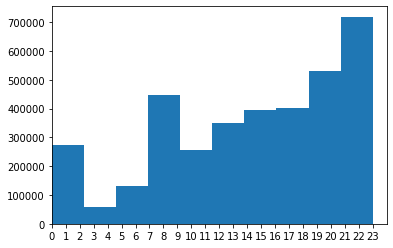

In [20]:
hour_list = [t.hour for t in df['tweet_date'].tolist()]
numbers = [x for x in range(0,24)]
labels = map(lambda x: str(x), numbers)
plt.xticks(numbers, labels)
plt.xlim(0,24)
plt.hist(hour_list)
plt.show()

The result is a bit surprising. I was expecting the tweet volume to increase more during lunch and then drop until 17:00 or 18:00 when people finish work. However, after the increase in volume at 12:00, the tweet counts per hour have been steadily increasing until 23:00. After that we see a sharp drop in volume of tweets.

In [21]:
print(' % of tweets with no likes: ', df[df['likes'] == 0]['likes'].count()/df.shape[0]*100,'\n',
      '% of tweets with at least 1 like: ', df[df['likes'] == 1]['likes'].count()/df.shape[0]*100,'\n',
      '% of tweets with at least 2 likes: ', df[df['likes'] == 2]['likes'].count()/df.shape[0]*100,'\n',
      '% of tweets with at least 3 likes: ', df[df['likes'] == 3]['likes'].count()/df.shape[0]*100,'\n',
      '% of tweets with at least 4 likes: ', df[df['likes'] == 4]['likes'].count()/df.shape[0]*100,'\n',
      '% of tweets with 5 or more likes: ', df[df['likes'] >= 5]['likes'].count()/df.shape[0]*100,'\n',
     'mean likes: ', df['likes'].mean(),'\n',
     'median likes: ', df['likes'].median(),'\n',
     'mode likes: ', df['likes'].mode())


 % of tweets with no likes:  44.291629085092545 
 % of tweets witat least 1 like:  29.952100511726997 
 % of tweets witat least 2 likes:  7.618497405151967 
 % of tweets witat least 3 likes:  3.688594655458024 
 % of tweets witat least 4 likes:  2.34337782486411 
 % of tweets with 5 or more likes:  12.105800517706362 
 mean likes:  6.738321078441693 
 median likes:  1.0 
 mode likes:  0    0
Name: likes, dtype: int64


From the above data we see that by far the most common number of likes is 0. With the mean laying to the right of the median, it also tells us that the distribution is right skewed.

Let's see if comments at a certain time of day are more likely to get more likes.

In [22]:
df['hour'] = pd.to_datetime(df['tweet_date']).dt.strftime('%H')
df.head()

,tweet_date,user_id,likes,replies,retweets,quoted_count,contains_media,contains_links,conversation_id,hashtags,...,followers,following,total_tweets,total_likes,total_media_tweets,protected,user_location,language,device,hour
0,2022-06-11 01:58:51+09:00,173143804,0,0,0,0,0,0,1535305506218450944,0,...,734,384,76115,23808,5661,False,福岡県,ja,Twitter for iPhone,01
1,2022-06-11 01:58:51+09:00,146142843,0,0,0,0,0,0,1535305505954234368,['スパイファミリー'],...,409,221,149670,9204,3635,False,こおりやま,ja,Twitter for iPhone,01
2,2022-06-11 01:58:51+09:00,2884471884,0,1,1,0,0,0,1535302493777047553,0,...,198,436,19873,1627,328,False,日本 東京,ja,Twitter for iPhone,01
3,2022-06-11 01:58:51+09:00,934377494181961728,0,1,0,0,0,0,1535304719106977793,0,...,95,218,21021,12111,4639,False,愛知県,ja,Twitter for iPhone,01
4,2022-06-11 01:58:51+09:00,988093376539967489,2,0,0,0,1,0,1535305505174073344,0,...,34,83,61,36,53,False,青島,ja,Twitter for iPhone,01


In [23]:
mean_likes = df[['hour','likes']].groupby('hour',as_index=False).mean()
mean_likes.head()

,hour,likes
0,00,5.029041
1,01,4.409157
2,02,3.697450
3,03,4.370170
4,04,12.168180


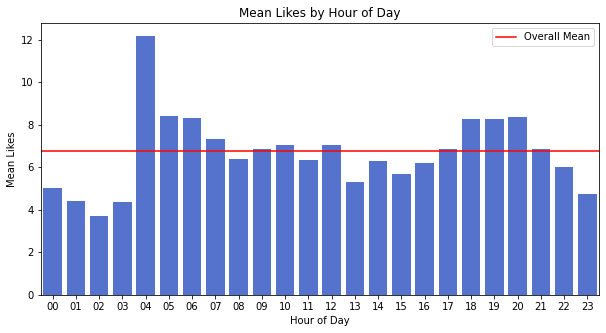

In [24]:
# changing graph size
plt.figure(figsize=(10,5))

# generating graph
graph = sns.barplot(x='hour',y='likes',data=mean_likes, color='royalblue')

# adding a horizontal line representing the overall mean
graph.axhline(df['likes'].mean(), color='red',label='Overall Mean')

# editing labels
graph.set(title='Mean Likes by Hour of Day')
graph.set_xlabel('Hour of Day')
graph.set_ylabel('Mean Likes')

plt.legend()
plt.show()

From the above data it looks like if someone wanted to maximize their chance of getting the most likes from their tweet, they should post it between 04:00-08:00 or 18:00-21:00.

Let's see if account age contributes to different number of likes.

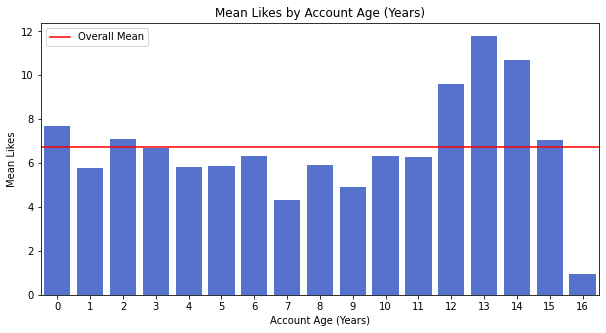

In [25]:
df['account_age'] = round((df['tweet_date'] - df['account_date']).dt.days / 365, 0).astype(int)
mean_likes_age = df[['account_age','likes']].groupby('account_age',as_index=False).mean()

# chaning graph size
plt.figure(figsize=(10,5))

# generating graph
graph = sns.barplot(x='account_age',y='likes',data=mean_likes_age, color='royalblue')

# adding a horizontal line representing the overall mean
graph.axhline(df['likes'].mean(), color='red',label='Overall Mean')

# editing labels
graph.set(title='Mean Likes by Account Age (Years)')
graph.set_xlabel('Account Age (Years)')
graph.set_ylabel('Mean Likes')

plt.legend()
plt.show()

It looks like account that were created 12-14 years ago get on average the most likes. However, accounts that were created within the last year also get above average likes, which could mean that account age might not have the most influence on average expected number of likes. Let's see what's the distribution for account age looks like.

In [26]:
# drop duplicate accounts
age_df = df.drop_duplicates(subset='user_id', keep='first')
age_df.shape

(643590, 25)

In [27]:
# count the likes (can be any column) to get the number of accounts active on that day
age_df = age_df[['account_age','likes']].groupby('account_age',as_index=False).count()
age_df.columns = ['account_age','count']
age_df.head()

,account_age,count
0,0,43966
1,1,63492
2,2,59100
3,3,51270
4,4,59905


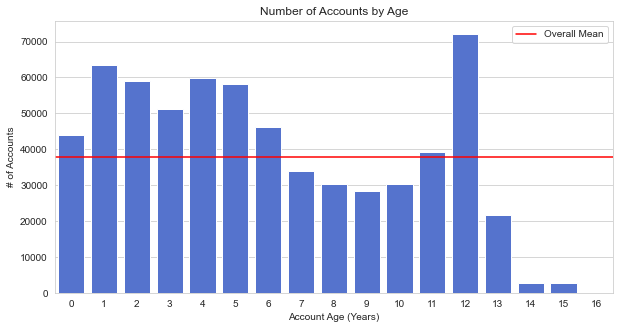

In [41]:
# chaning graph size
plt.figure(figsize=(10,5))

# generating graph
graph = sns.barplot(x='account_age',y='count',data=age_df, color='royalblue')

# adding a horizontal line representing the overall mean
graph.axhline(age_df['count'].mean(), color='red',label='Overall Mean')

# editing labels
graph.set(title='Number of Accounts by Age')
graph.set_xlabel('Account Age (Years)')
graph.set_ylabel('# of Accounts')

plt.legend()
plt.show()

It looks like accounts that have been create within the last 7 years have been the most active on this day. This could mean that there have been more users registering within recent years or that older accounts are not as active. An interesting exception to this are accounts that were created 12 years ago, these accounts had the most activity.

Insted of checking each variable separately, let's create a plot that shows us a corellation for our quantitative variables.

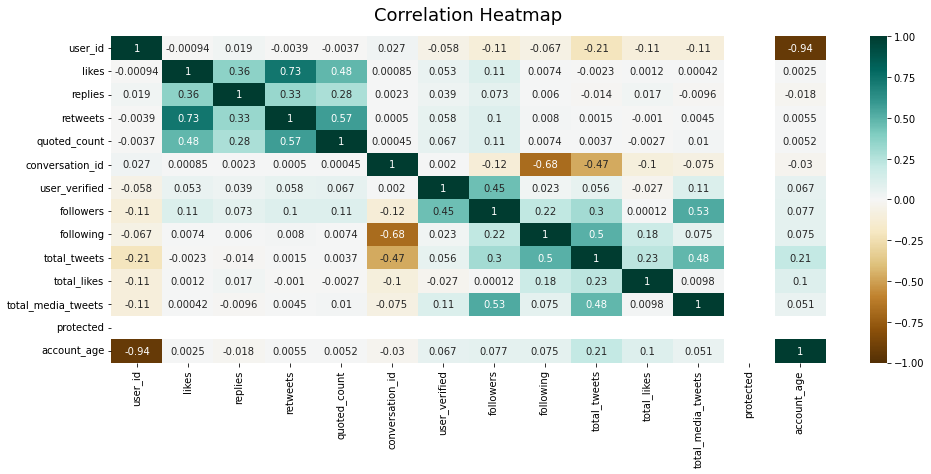

In [29]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

One definitive thing we learned from above graph that account age is negatively correlated with user_id, but this just means that user_id values are integers that increase as more people register with twitter.

I was also expecting to see contains_media and contains_links columns but it looks like the datatype was not saved as int or float. Let's also change the verified values to (1,0), and created a new cashtag and hashtag values and then check correlations again.

While we're at it, let's also add the twitter content character length count and see if longer tweets lead to more likes.

In [30]:
df['contains_links'] = df.contains_links.astype(int)
df['contains_media'] = df.contains_media.astype(int)

# pandas will automatically convert bool values to 1s and 0s
df['user_verified'] = df['user_verified'].astype(int)

# adding content length column
df['tweet_length']  = df['tweet_content'].str.len()

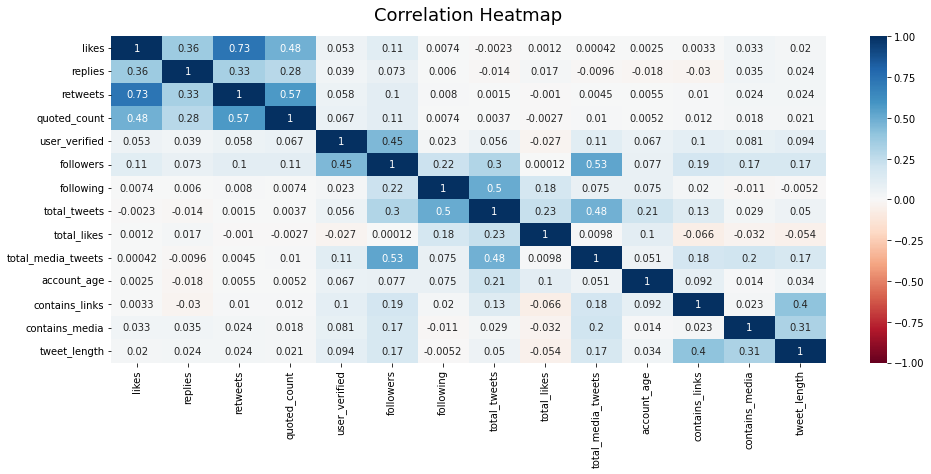

In [31]:
plt.figure(figsize=(16, 6))


heatmap = sns.heatmap(df[['likes','replies','retweets','quoted_count','user_verified',
                               'followers','following','total_tweets','total_likes','total_media_tweets',
                               'account_age','contains_links','contains_media','tweet_length']].corr(), 
                      vmin=-1, vmax=1, annot=True, cmap='RdBu')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In the above correlation graph we see that likes, replies, retweets, and quotes are all positively correlated with each other. This is not that surprising, people are more likely to share content they like and like content they want to share.

We also learned that tweet_length has no correlation with likes, so typing more will not necessarily lead to tweets being liked more.

Some of the other interesting positive correlations that we see are:
* **total_media_tweets and followers (0.53)** - moderate positive correlation indicating that the more images,gifs,videos a user posts, the more likely are they to have more followers
* **total_tweets and following (0.5)** - moderate positive correlation indicating a relationship between volume of tweets and the number of people the user follows
* **total_tweets and total_media_tweets (0.48)** - weak positive correlation indicating that users that post a lot of media content tend to make a lot of posts

Quite surprising to find out was that follower count is so weakly correlated with likes. I expected accounts with more followers to get more likes on their tweets. Let's look at this data a bit closer.

In [32]:
print(' min followers: ', df.followers.min(),'\n',
     'max followers: ', df.followers.max(),'\n',
     'mean followers: ', df.followers.mean(),'\n',
     'median followers: ', df.followers.median(),'\n',
      'mode followers: ', df.followers.mode(),'\n'
     'tweets by users with no followers: ', df['followers'].loc[df['followers'] == 0].count())

 min followers:  0 
 max followers:  6224069 
 mean followers:  4642.689318074442 
 median followers:  368.0 
 mode followers:  0    0
Name: followers, dtype: int64 
tweets by users with no followers:  19265


The mean laying to the right of the median tells us that the distribution is right skewed. Let's visualize it.

In [33]:
df['decile_followers_rank'] = pd.qcut(df['followers'], 10, labels = False)
followers_df = df[['followers','likes','decile_followers_rank']].groupby(
    'decile_followers_rank',as_index=False).mean()

followers_df.columns = ['decile_followers_rank','mean_followers','mean_likes']

followers_df.head(10)

,decile_followers_rank,mean_followers,mean_likes
0,0,17.539502,0.931286
1,1,65.654349,1.455764
2,2,126.651183,1.901136
3,3,204.267005,2.221566
4,4,305.766595,2.618060
5,5,448.758185,3.368421
6,6,670.696671,3.828180
7,7,1060.452185,4.618464
8,8,1936.588604,6.717954
9,9,41608.511015,39.749412


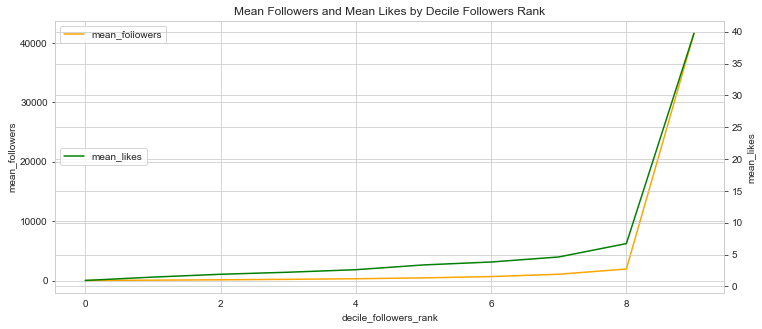

In [34]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12,5))


ax = sns.lineplot(x='decile_followers_rank', y='mean_followers', data=followers_df, color='orange', ax=ax)
ax2 = ax.twinx()
sns.lineplot(x='decile_followers_rank', y='mean_likes', data=followers_df, color='green', markers=True, ax=ax2)


ax.legend(['mean_followers'])
ax2.legend(['mean_likes'],loc='center left')
ax.set(title='Mean Followers and Mean Likes by Decile Followers Rank')


plt.show()

Looking at the above table we see that the followers count and likes are indeed correlated. However, to reach an overall mean of 6.7 likes, on average a user needs to be in the **9th decile of the followers rank**.


Let's see what type of hashtags were trending on Friday.

In [35]:
# iterate over all hashtags and count occurences

hashtag_dict = {}

for hashtags in df['hashtags'].tolist():
    if hashtags != 0:
        for hashtag in pd.eval(hashtags):
            hashtag_dict[hashtag] = hashtag_dict.get(hashtag, 0) + 1

In [36]:
# converting the hashtag dictionary into a pd df
hash_df = pd.DataFrame(hashtag_dict.items(),columns=['hashtag', 'count'])

# descending sort on counts of most used hashtags and removal of the index
hash_df = hash_df.sort_values(['count'], ascending=False).reset_index()
hash_df = hash_df.drop('index',1)
hash_df.head(10)

/var/folders/3m/w_xtc04n3tg928zm5h2rc5k00000gp/T/ipykernel_65143/2086062599.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  hash_df = hash_df.drop('index',1)


,hashtag,count
0,質問箱,32790
1,匿名質問募集中,28249
2,Yahooニュース,6084
3,shindanmaker,5759
4,Mステ,5178
5,Peing,4447
6,ミクダヨーサンオミクジ,3623
7,アメブロ,3107
8,rakuafl,2919
9,配信,2731


In [37]:
# % of tweets that contains hashtags
df['hashtags'].loc[df['hashtags'] != 0].count()/df['hashtags'].count()*100

12.393848720935162

* Some popular hashtags:
    * It looks like the most trending hashtags was 質問箱 (question box) hosted on the website called Peing. A user writes a question and it appears like it is handwritten on a sticky note. Other users then answer the question on a sticky note on twitter and share it with their friends. One of the first questions that popped up when searching the hashtag was "if your schedule was suddenly open on a weekend, what would you do?" ([link here](https://peing.net/ja/q/29b9a69d-2721-4313-a037-109cb75115ac)).
    * Next on the list is Yahoo news which needs not explanation
    * Then we have shindanmaker which seems to operate on a similar basis as the (questions box). One of first results was a question: あなたがモテない原因上位5つを調べます (5 reasons you are unattractive)
    * Mステ (music station) - looks like a boy band called King Stix was popular on that day
    
Let's see what popular cashtags did we see on that day.

In [38]:
# iterate over all hashtags and count occurences

cashtag_dict = {}

for cashtags in df['cashtags'].tolist():
    if cashtags != 0:
        for cashtag in pd.eval(cashtags):
            cashtag_dict[cashtag] = cashtag_dict.get(cashtag, 0) + 1
            
# converting the hashtag dictionary into a pd df
cash_df = pd.DataFrame(cashtag_dict.items(),columns=['hashtag', 'count'])

# descending sort on counts of most used hashtags and removal of the index
cash_df = cash_df.sort_values(['count'], ascending=False).reset_index()
cash_df = cash_df.drop('index',1)
cash_df.head(5)

/var/folders/3m/w_xtc04n3tg928zm5h2rc5k00000gp/T/ipykernel_65143/1419421867.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cash_df = cash_df.drop('index',1)


,hashtag,count
0,TSLA,34
1,BTCJPY,24
2,HIRSHI,24
3,DOCU,18
4,GST,18


In [39]:
# % of tweets that contains hashtags
df['cashtags'].loc[df['cashtags'] != 0].count()/df['cashtags'].count()*100

0.014429078692096656

With only 0.01% of tweets containing cashtags (stock exchange ticker symbols), it looks like finance conversations are not really taking place on Twitter in Japan.

Finally, let's see what devices are people using to post their tweets with.

In [40]:
df.device.value_counts().head(20)

Twitter for iPhone       1772461
Twitter for Android       876352
Twitter Web App           360986
twittbot.net              159051
Twitter for iPad           46541
OWNLY Admin                37238
Peing                      32799
TweetDeck                  29794
グランブルー ファンタジー              22889
Botbird tweets             11813
Instagram                  11252
Foursquare                  9828
WordPress.com               5835
Foursquare Swarm            5134
feather for iOS             5063
今日のツイライフ                    5036
SocialDog for Twitter       4744
TwitPane for Android        4485
Tweetbot for iΟS            4245
Echofon                     4149
Name: device, dtype: int64

It looks like there are many different devices and platforms from which users may post tweets. The two most popular being iPhone and Android phones.